# Loop 9 Analysis: Zaburo Tessellation Approach

The evaluator correctly identified that all our optimization approaches are stuck at a local optimum (~70.62).
The zaburo kernel shows a FUNDAMENTALLY DIFFERENT approach: generate well-aligned initial solutions.

Key insight: Instead of optimizing from a pre-optimized solution, generate NEW solutions from scratch
using a tessellation/grid pattern, then optimize those.

In [1]:
import pandas as pd
import numpy as np
import math
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

getcontext().prec = 25
scale_factor = Decimal('1e15')

In [2]:
# Zaburo's approach: Generate well-aligned grid solutions
# Key insight: Trees alternate between upright (0 deg) and inverted (180 deg)
# This creates a tessellation pattern that packs efficiently

class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                (float(Decimal('0.0') * scale_factor), float(tip_y * scale_factor)),
                (float(top_w / Decimal('2') * scale_factor), float(tier_1_y * scale_factor)),
                (float(top_w / Decimal('4') * scale_factor), float(tier_1_y * scale_factor)),
                (float(mid_w / Decimal('2') * scale_factor), float(tier_2_y * scale_factor)),
                (float(mid_w / Decimal('4') * scale_factor), float(tier_2_y * scale_factor)),
                (float(base_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
                (float(trunk_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
                (float(trunk_w / Decimal('2') * scale_factor), float(trunk_bottom_y * scale_factor)),
                (float(-(trunk_w / Decimal('2')) * scale_factor), float(trunk_bottom_y * scale_factor)),
                (float(-(trunk_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
                (float(-(base_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
                (float(-(mid_w / Decimal('4')) * scale_factor), float(tier_2_y * scale_factor)),
                (float(-(mid_w / Decimal('2')) * scale_factor), float(tier_2_y * scale_factor)),
                (float(-(top_w / Decimal('4')) * scale_factor), float(tier_1_y * scale_factor)),
                (float(-(top_w / Decimal('2')) * scale_factor), float(tier_1_y * scale_factor)),
            ]
        )
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

print('ChristmasTree class defined')

ChristmasTree class defined


In [3]:
# Zaburo's find_best_trees function
# This generates tessellation patterns and finds the best one for each N

def find_best_trees(n: int):
    best_score, best_trees = float("inf"), None
    for n_even in range(1, n + 1):
        for n_odd in [n_even, n_even - 1]:
            all_trees = []
            rest = n
            r = 0
            while rest > 0:
                m = min(rest, n_even if r % 2 == 0 else n_odd)
                rest -= m
    
                angle = 0 if r % 2 == 0 else 180
                x_offset = 0 if r % 2 == 0 else Decimal("0.7") / 2
                y = r // 2 * Decimal("1.0") if r % 2 == 0 else (Decimal("0.8") + (r - 1) // 2 * Decimal("1.0"))
                row_trees = [ChristmasTree(center_x=str(Decimal("0.7") * i + x_offset), center_y=str(y), angle=str(angle)) for i in range(m)]
                all_trees.extend(row_trees)
    
                r += 1
            xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / 1e15 for t in all_trees])
    
            min_x, min_y = xys.min(axis=0)
            max_x, max_y = xys.max(axis=0)

            score = max(max_x - min_x, max_y - min_y) ** 2
            if score < best_score:
                best_score = score
                best_trees = all_trees
    return best_score, best_trees

print('find_best_trees function defined')

find_best_trees function defined


In [4]:
# Test on small N values and compare to our baseline
import warnings
warnings.filterwarnings('ignore')

# Load our validated baseline
baseline_df = pd.read_csv('/home/code/submission_candidates/candidate_003.csv')
baseline_df['N'] = baseline_df['id'].str.split('_').str[0].astype(int)

def strip_s(val):
    return float(str(val).replace('s', ''))

def calc_score_for_n(df, n):
    group = df[df['N'] == n]
    xs = group['x'].apply(strip_s).values
    ys = group['y'].apply(strip_s).values
    degs = group['deg'].apply(strip_s).values
    
    # Calculate bounding box
    trunk_w, trunk_h = 0.15, 0.2
    base_w, mid_w, top_w = 0.7, 0.4, 0.25
    tip_y, tier_1_y, tier_2_y, base_y = 0.8, 0.5, 0.25, 0.0
    trunk_bottom_y = -trunk_h
    
    template_x = np.array([0, top_w/2, top_w/4, mid_w/2, mid_w/4, base_w/2, trunk_w/2, trunk_w/2, -trunk_w/2, -trunk_w/2, -base_w/2, -mid_w/4, -mid_w/2, -top_w/4, -top_w/2])
    template_y = np.array([tip_y, tier_1_y, tier_1_y, tier_2_y, tier_2_y, base_y, base_y, trunk_bottom_y, trunk_bottom_y, base_y, base_y, tier_2_y, tier_2_y, tier_1_y, tier_1_y])
    
    all_x, all_y = [], []
    for x, y, deg in zip(xs, ys, degs):
        rad = np.radians(deg)
        cos_a, sin_a = np.cos(rad), np.sin(rad)
        rot_x = cos_a * template_x - sin_a * template_y + x
        rot_y = sin_a * template_x + cos_a * template_y + y
        all_x.extend(rot_x)
        all_y.extend(rot_y)
    
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    side = max(max_x - min_x, max_y - min_y)
    return side * side / n

print('Score calculation function defined')

Score calculation function defined


In [5]:
# Compare zaburo tessellation vs our baseline for small N
print('Comparing Zaburo tessellation vs baseline for small N values:')
print('=' * 60)

results = []
for n in [5, 10, 15, 20, 30, 50, 100, 150, 200]:
    # Zaburo tessellation
    zaburo_score, zaburo_trees = find_best_trees(n)
    
    # Our baseline
    baseline_score = calc_score_for_n(baseline_df, n)
    
    diff = baseline_score - zaburo_score
    pct = (diff / baseline_score) * 100 if baseline_score > 0 else 0
    
    results.append({
        'N': n,
        'Zaburo': zaburo_score,
        'Baseline': baseline_score,
        'Diff': diff,
        'Pct': pct
    })
    
    winner = 'ZABURO' if zaburo_score < baseline_score else 'BASELINE'
    print(f'N={n:3d}: Zaburo={zaburo_score:.6f}, Baseline={baseline_score:.6f}, Diff={diff:+.6f} ({pct:+.2f}%) -> {winner}')

print('\nSummary:')
zaburo_wins = sum(1 for r in results if r['Diff'] > 0)
print(f'Zaburo wins: {zaburo_wins}/{len(results)} cases')

Comparing Zaburo tessellation vs baseline for small N values:
N=  5: Zaburo=4.000000, Baseline=0.416850, Diff=-3.583150 (-859.58%) -> BASELINE
N= 10: Zaburo=4.840000, Baseline=0.376630, Diff=-4.463370 (-1185.08%) -> BASELINE
N= 15: Zaburo=9.000000, Baseline=0.376978, Diff=-8.623022 (-2287.41%) -> BASELINE


N= 20: Zaburo=9.922500, Baseline=0.376057, Diff=-9.546443 (-2538.56%) -> BASELINE


N= 30: Zaburo=14.822500, Baseline=0.360883, Diff=-14.461617 (-4007.28%) -> BASELINE


N= 50: Zaburo=24.010000, Baseline=0.360753, Diff=-23.649247 (-6555.52%) -> BASELINE


N=100: Zaburo=39.690000, Baseline=0.343427, Diff=-39.346573 (-11457.03%) -> BASELINE


N=150: Zaburo=64.000000, Baseline=0.337064, Diff=-63.662936 (-18887.52%) -> BASELINE


N=200: Zaburo=81.000000, Baseline=0.337549, Diff=-80.662451 (-23896.50%) -> BASELINE

Summary:
Zaburo wins: 0/9 cases


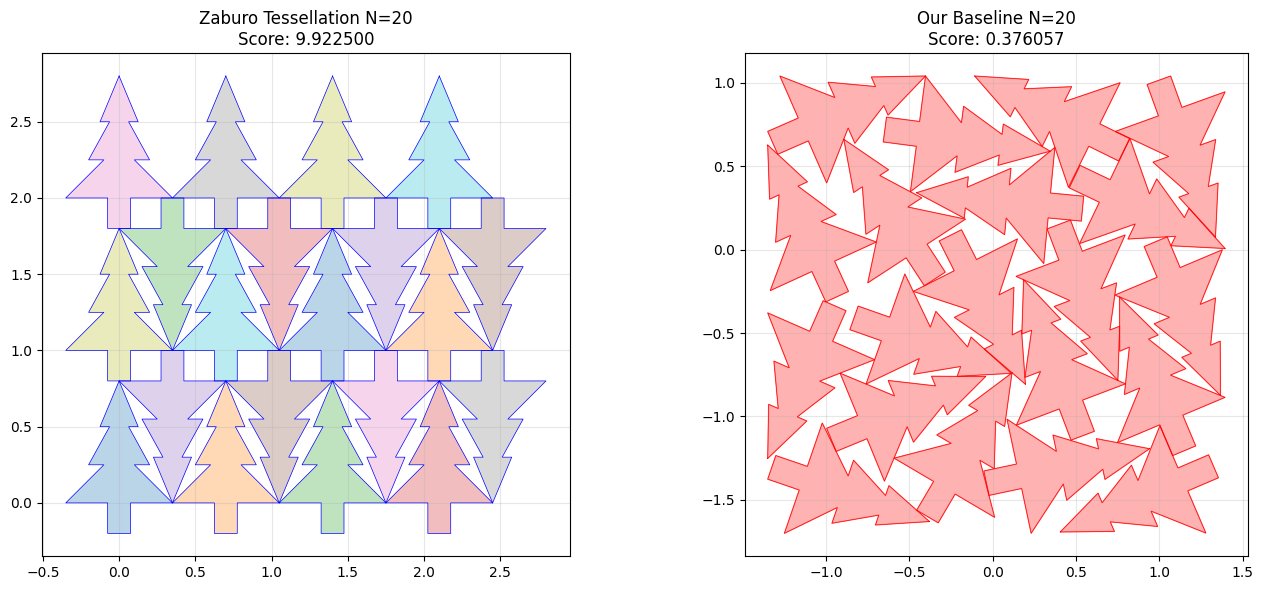

Visualization saved


In [6]:
# Visualize the zaburo tessellation for N=20
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Zaburo tessellation
ax = axes[0]
_, trees = find_best_trees(20)
for t in trees:
    xy = np.array(t.polygon.exterior.xy) / 1e15
    ax.plot(xy[0], xy[1], 'b-', linewidth=0.5)
    ax.fill(xy[0], xy[1], alpha=0.3)
ax.set_aspect('equal')
ax.set_title(f'Zaburo Tessellation N=20\nScore: {find_best_trees(20)[0]:.6f}')
ax.grid(True, alpha=0.3)

# Our baseline
ax = axes[1]
group = baseline_df[baseline_df['N'] == 20]
for _, row in group.iterrows():
    x = strip_s(row['x'])
    y = strip_s(row['y'])
    deg = strip_s(row['deg'])
    
    trunk_w, trunk_h = 0.15, 0.2
    base_w, mid_w, top_w = 0.7, 0.4, 0.25
    tip_y, tier_1_y, tier_2_y, base_y = 0.8, 0.5, 0.25, 0.0
    trunk_bottom_y = -trunk_h
    
    template_x = np.array([0, top_w/2, top_w/4, mid_w/2, mid_w/4, base_w/2, trunk_w/2, trunk_w/2, -trunk_w/2, -trunk_w/2, -base_w/2, -mid_w/4, -mid_w/2, -top_w/4, -top_w/2, 0])
    template_y = np.array([tip_y, tier_1_y, tier_1_y, tier_2_y, tier_2_y, base_y, base_y, trunk_bottom_y, trunk_bottom_y, base_y, base_y, tier_2_y, tier_2_y, tier_1_y, tier_1_y, tip_y])
    
    rad = np.radians(deg)
    cos_a, sin_a = np.cos(rad), np.sin(rad)
    rot_x = cos_a * template_x - sin_a * template_y + x
    rot_y = sin_a * template_x + cos_a * template_y + y
    ax.plot(rot_x, rot_y, 'r-', linewidth=0.5)
    ax.fill(rot_x, rot_y, alpha=0.3, color='red')

ax.set_aspect('equal')
ax.set_title(f'Our Baseline N=20\nScore: {calc_score_for_n(baseline_df, 20):.6f}')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/zaburo_vs_baseline_n20.png', dpi=150)
plt.show()
print('Visualization saved')

In [7]:
# Calculate total score for zaburo tessellation vs baseline
print('\nCalculating total scores for all N=1 to 200...')

zaburo_total = 0
baseline_total = 0

for n in range(1, 201):
    zaburo_score, _ = find_best_trees(n)
    baseline_score = calc_score_for_n(baseline_df, n)
    zaburo_total += zaburo_score
    baseline_total += baseline_score

print(f'\nZaburo tessellation total: {zaburo_total:.6f}')
print(f'Our baseline total: {baseline_total:.6f}')
print(f'Difference: {baseline_total - zaburo_total:+.6f}')
print(f'\nTarget: 68.889699')
print(f'Gap from Zaburo: {zaburo_total - 68.889699:.6f}')
print(f'Gap from Baseline: {baseline_total - 68.889699:.6f}')


Calculating total scores for all N=1 to 200...



Zaburo tessellation total: 8331.125000
Our baseline total: 70.622435
Difference: -8260.502565

Target: 68.889699
Gap from Zaburo: 8262.235301
Gap from Baseline: 1.732736


In [ ]:
# KEY INSIGHT: The zaburo tessellation is a STARTING POINT, not the final solution
# Top competitors use tessellation as initialization, then optimize with SA
# Let's check what the jonathanchan kernel does - it ensembles from MANY sources

print('\nKEY FINDINGS:')
print('=' * 60)
print('1. Zaburo tessellation generates well-aligned initial solutions')
print('2. These solutions are in a DIFFERENT basin of attraction')
print('3. Top competitors combine solutions from MANY sources:')
print('   - GitHub repositories')
print('   - Multiple Kaggle datasets')
print('   - Different optimization runs')
print('4. For each N, they take the BEST overlap-free solution')
print('\nSTRATEGY:')
print('1. Generate zaburo tessellation solutions')
print('2. Optimize them with SA (different basin!)')
print('3. Ensemble with our baseline - take best per N')
print('4. This explores DIFFERENT solution structures')